In [ ]:
# 4 agents: renewable, gas exit, gas entry, coal exit

In [7]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import linprog
import matplotlib
import matplotlib.pyplot as plt
import time
from cvxopt import solvers, matrix, sparse
from scipy.optimize import root_scalar
from scipy.sparse import bsr_matrix
from scipy.stats import gamma
from scipy.stats import beta
from scipy.linalg import block_diag
import random

In [8]:
# interval
Smin = 0.1
Smax = 0.7
Cmin = 0
Cmax = 120
tmin = 0
tmax = 30

# number for points
NS = 41
NC = 41
Nt = 101

# discretization
dS = 1.*(Smax-Smin)/(NS-1)
dC = 1.*(Cmax-Cmin)/(NC-1)
dt = 1.*(tmax-tmin)/(Nt-1)

# define grid in space
S = np.linspace(Smin,Smax,NS)
C = np.linspace(Cmin,Cmax,NC)
T = np.linspace(tmin,tmax,Nt)

# long-term average cost
theta_G = 37.94
theta_C = 22.5
theta_R = 0.4

# standard deviation
std_G = 12.53
std_C = 10
std_R = 0.075

# rate of mean reversion
kG = 0.5
kC = 0.5
kR = 0.5

# variability of the cost process 
delta_G = std_G*np.sqrt(2.*kG/theta_G)
delta_C = std_C*np.sqrt(2.*kC/theta_C)
delta_R = std_R*np.sqrt(2.*kR/(theta_R*(1-theta_R)-std_R*std_R))

rho = 0.08

epsilon = 0.5

# depreciation rate
gamma_G = np.log(2.)/15.
gamma_C = np.log(2.)/20.
gamma_R = np.log(2.)/12.5

# conversion of hourly revenue per MW into annual revenue per kW
convcoef = 24.*365.25/1000. 

# maximal price 
P = 150.

K_R = 1500. # per kW of installed capacity (who enter - fixing cost of owning the plant)
K_G_enter = 1450 # per kW of installed capacity (who enter - fixing cost of owning the plant)
K_G = 0 # per kW of installed capacity (who exit - value recovered if the plant is sold)
K_C = 0 # per kW of installed capacity (who exit - value recovered if the plant is sold)

# fixed cost
k_G = 32. # per kW per year
k_C = 58. # per kW per year
k_R = 30. # per kW per year

# coef carbon emission (tCO2/kWh)
ctax_G = 0.429
ctax_C = 0.986

# initial condition gas producers who exit
alpha_G = (theta_G/std_G)*(theta_G/std_G)
beta_G = theta_G/std_G/std_G
InitialOmega = 32*beta_G*gamma.pdf(beta_G*C,alpha_G)
# initial condition gas producers who enter
InitialLambda = 36.*beta_G*gamma.pdf(beta_G*C,alpha_G)
BarLambda = 36.*beta_G*gamma.pdf(beta_G*C,alpha_G)

# initial condition coal producers who exit
alpha_C = (theta_C/std_C)*(theta_C/std_C)
beta_C = theta_C/std_C/std_C
InitialMu = 44.9*beta_C*gamma.pdf(beta_C*C,alpha_C)

# initial condition renewable producers
alpha_R = theta_R*(theta_R*(1.-theta_R)/std_R/std_R-1.)
beta_R = (1.-theta_R)*(theta_R*(1.-theta_R)/std_R/std_R-1.)
BarEta = 118.3*beta.pdf(S,alpha_R,beta_R)
InitialEta = 64.*beta.pdf(S,alpha_R,beta_R)

# demand
demand = np.array([58.17932923,58.17932923,58.17932923,58.17932923
                    ,58.00821355,58.00821355,58.00821355,58.00821355
                    ,57.3709788,57.3709788,57.3709788,57.3709788
                    ,57.6659822,57.6659822,57.6659822,57.6659822
                    ,57.49486653,57.49486653,57.49486653,57.49486653
                    ,57.32375086,57.32375086,57.32375086,57.32375086
                    ,57.15263518,57.15263518,57.15263518,57.15263518
                    ,56.98151951,56.98151951,56.98151951,56.98151951
                    ,56.81040383,56.81040383,56.81040383,56.81040383
                    ,56.63928816,56.63928816,56.63928816,56.63928816
                    ,56.46817248,56.46817248,56.46817248,56.46817248
                    ,56.39972621,56.39972621,56.39972621,56.39972621
                    ,56.33127995,56.33127995,56.33127995,56.33127995
                    ,56.26283368,56.26283368,56.26283368,56.26283368
                    ,56.19438741,56.19438741,56.19438741,56.19438741
                    ,56.12594114,56.12594114,56.12594114,56.12594114
                    ,56.05749487,56.05749487,56.05749487,56.05749487
                    ,55.9890486,55.9890486,55.9890486,55.9890486
                    ,55.92060233,55.92060233,55.92060233,55.92060233
                    ,55.85215606,55.85215606,55.85215606,55.85215606
                    ,55.78370979,55.78370979,55.78370979,55.78370979
                    ,55.86356377,55.86356377,55.86356377,55.86356377
                    ,55.94341775,55.94341775,55.94341775,55.94341775
                    ,56.02327173,56.02327173,56.02327173,56.02327173
                    ,56.10312571,56.10312571,56.10312571,56.10312571
                    ,56.18297969,56.18297969,56.18297969,56.18297969
                    ,56.26283368,56.26283368,56.26283368,56.26283368
                    ,56.34268766,56.34268766,56.34268766,56.34268766
                    ,56.42254164,56.42254164,56.42254164,56.42254164
                    ,56.50239562,56.50239562,56.50239562,56.50239562
                    ,56.5822496,56.5822496,56.5822496,56.5822496])

# Adjusting for seasonal cycle
sc = np.array([[1.052491152, 0.962461095, 0.953705412, 1.037144059]])

sc = np.repeat(sc,len(demand)/4,axis=0)
sc = np.reshape(sc,1*len(demand))
demand[:101] = demand[:101]*sc[:101]
demand[100] = demand[100]*sc[0]

# peak / offpeak demand ratio
Dc = 1.257580634655325

# peak hours
pcoef = 65./168
# off-peak hours
opcoef = 1.-pcoef

# peak demand
pdemand = demand*Dc/(pcoef*Dc+opcoef)
# off-peak demand
opdemand = demand/(pcoef*Dc+opcoef)

# fonction G in the definition of the reward function for exit
def G(x):
    return (epsilon/2+(x-epsilon))*(x>epsilon)+x*x/2/epsilon*(x>0)*(x<=epsilon)

def F(x):
    return (x-epsilon>0)+x/epsilon*(x>0)*(x<=epsilon)

# baseline supply
def F0(X):
    return 17.5*X/150.

# fonction ptax - price carbon tax
def ptax(t):
    return 1.1*(5.*t-10050)


# fonction g - payoff exit gas player
def g(x,p,t):
    return convcoef*G(p-x) - ctax_G*ptax(2020+t)*F(p-x) - k_G - (rho+gamma_G)*K_G*np.exp(-gamma_G*t)

# function h - payoff entry gas player
def h(x,p,t):
    return -convcoef*G(p-x) + ctax_G*ptax(2020+t)*F(p-x) + k_G + rho*K_G_enter + gamma_G*K_G_enter*np.exp(-(rho+gamma_G)*(tmax-t))

# fonction f - payoff entry renewable player
def f(x,p,t):
    return -convcoef*p*x + k_R + rho*K_R + gamma_R*K_R*np.exp(-(rho+gamma_R)*(tmax-t))

# fonction l - payoff exit coal player
def l(x,p,t):
    return convcoef*G(p-x) - ctax_C*ptax(2020+t)*F(p-x) - k_C - (rho+gamma_C)*K_C*np.exp(-gamma_C*t)

# residual demand
def computeR(eta,dem):
    maxdem = sum(S[:-1]*BarEta[0:NS-1])*dS
    Eta = np.reshape(eta,(Nt,NS))
    R = dem[:Nt]+np.matmul(Eta,S)*dS-maxdem
    return (R[:Nt]*(R[:Nt]>0))

# total supply by the conventional gas producers at prive level p
def computeM(l, p):
    maxdem = sum(F(p-C[:-1])*BarLambda[0:NC-1])*dC
    Lamb = np.reshape(l,(Nt,NS))
    M = maxdem - np.matmul(Lamb,F(p-C))*dC    
    return M 

# function which computes the price for given densities at a given time t
def price(t,R,O,L,M):
    if R[t]==0: return 0
    def func(x):
        return sum(F(x-C)*(O[t*NC:(t+1)*NC]+M[t*NC:(t+1)*NC]))*dC-R[t]+F0(x)+computeM(L,x)[t]
    if func(P)<=0: return P
    return root_scalar(func,bracket=(0.,P),x0 = P/2).root 

################################################################################################################
# find the maximum on omega at a given iteration
################################################################################################################
def OptExit_G(Omega,Eta,Lambda,Mu,Prp,Prop):
    # constraints    
    H=np.zeros(Nt*NC)
    for i in range(Nt):
        H[i*NC:(i+1)*NC]=dC*dt*np.exp(-rho*(T[i]))*(pcoef*g(C,Prp[i],T[i])+opcoef*g(C,Prop[i],T[i]))
    
    # neumann conditions
    A=np.zeros((NC,NC))
    V=1.+delta_G*delta_G*C*dt/(dC*dC)
    V1 =-delta_G*delta_G*C[1:]*dt/(2*dC*dC)+kG*(theta_G-C[1:])*dt/(2*dC)
    V2=-delta_G*delta_G*C[:-1]*dt/(2*dC*dC)-kG*(theta_G-C[:-1])*dt/(2*dC)
    A.flat[::NC+1] = V
    A.flat[1::NC+1] = V1
    A.flat[NC::NC+1] = V2

    A_ub = np.zeros(((Nt-1)*NC,(Nt-1)*NC))
    for i in range(Nt-1):
        A_ub[((i)*NC):((i+1)*NC), ((i)*NC):((i+1)*NC)] = A
    for i in range(Nt-2):
        A_ub[((i+1)*NC):((i+2)*NC), ((i)*NC):((i+1)*NC)] = -np.diag(np.ones(NC))
    b_ub=np.zeros((Nt-1)*NC)
    b_ub[:NC] = InitialOmega
    
    t0 = time.time()
    res = linprog(-H[NC:],A_ub,b_ub,method="highs-ipm")

    M1 = res.x
    val = np.dot(H[NC:],Omega[NC:])
    ob_func = np.dot(H[NC:],M1)- val
    t1 = time.time()

    return ob_func, val, M1

################################################################################################################
# find the maximum on lambda at a given iteration
################################################################################################################
def OptEntry_G(Omega,Eta,Lambda,Mu,Prp,Prop):
    # constraints    
    H=np.zeros(Nt*NC)
    for i in range(Nt):
        H[i*NC:(i+1)*NC]=dC*dt*np.exp(-rho*(T[i]))*(pcoef*h(C,Prp[i],T[i])+opcoef*h(C,Prop[i],T[i]))
    
    # neumann conditions
    A=np.zeros((NC,NC))
    V=1.+delta_G*delta_G*C*dt/(dC*dC)
    V1 =-delta_G*delta_G*C[1:]*dt/(2*dC*dC)+kG*(theta_G-C[1:])*dt/(2*dC)
    V2=-delta_G*delta_G*C[:-1]*dt/(2*dC*dC)-kG*(theta_G-C[:-1])*dt/(2*dC)
    A.flat[::NC+1] = V
    A.flat[1::NC+1] = V1
    A.flat[NC::NC+1] = V2

    
    A_ub = np.zeros(((Nt-1)*NC,(Nt-1)*NC))
    for i in range(Nt-1):
        A_ub[((i)*NC):((i+1)*NC), ((i)*NC):((i+1)*NC)] = A
    for i in range(Nt-2):
        A_ub[((i+1)*NC):((i+2)*NC), ((i)*NC):((i+1)*NC)] = -np.diag(np.ones(NC))
    b_ub=np.zeros((Nt-1)*NC)
    b_ub[:NC] = InitialLambda

    t0 = time.time()
    res = linprog(-H[NC:],A_ub,b_ub,method="highs-ipm")
    if(res.status): print('OpExit: '+res.message)

    M1 = res.x
    val = np.dot(H[NC:],Lambda[NC:])
    ob_func = np.dot(H[NC:],M1)- val
    t1 = time.time()

    return ob_func, val, M1

################################################################################################################
# find the maximum on eta at a given iteration
################################################################################################################
def OptEntry_R(Omega,Eta,Lambda,Mu,Prp,Prop):
    # constraints
    barH=np.zeros(Nt*NS)
    for i in range(Nt):
        barH[i*NS:(i+1)*NS]=dS*dt*np.exp(-rho*T[i])*(pcoef*f(S,Prp[i],T[i])+opcoef*f(S,Prop[i],T[i]))        
    
    # neumann conditions
    barA=np.zeros((NS,NS))
    barV=1.+delta_R*delta_R*S*(1-S)*dt/(dS*dS)
    barV1 = -delta_R*delta_R*S[1:]*(1.-S[1:])*dt/(2*dS*dS)+kR*(theta_R-S[1:])*dt/(2*dS)
    barV2 = -delta_R*delta_R*S[:-1]*(1.-S[:-1])*dt/(2*dS*dS)-kR*(theta_R-S[:-1])*dt/(2*dS)
    barA.flat[::NS+1] = barV
    barA.flat[1::NS+1] = barV1
    barA.flat[NS::NS+1] = barV2

    A_ub = np.zeros(((Nt-1)*NS,(Nt-1)*NS))
    for i in range(Nt-1):
        A_ub[((i)*NS):((i+1)*NS), ((i)*NS):((i+1)*NS)] = barA
    for i in range(Nt-2):
        A_ub[((i+1)*NS):((i+2)*NS), ((i)*NS):((i+1)*NS)] = -np.diag(np.ones(NS))
    b_ub=np.zeros((Nt-1)*NS)
    b_ub[:NS] = InitialEta

    t0 = time.time()
    res = linprog(-barH[NS:],bsr_matrix(A_ub),b_ub,method="interior-point",options={"sparse":True,"rr":False})
    if(res.status): print('OpEntry: '+res.message)

    M1 = res.x
    val = np.dot(barH[NS:],Eta[NS:])
    ob_func = np.dot(barH[NS:],M1)- val
    t1 = time.time()

    return ob_func, val, M1

################################################################################################################
# find the maximum on mu at a given iteration
################################################################################################################
def OptExit_C(Omega,Eta,Lambda,Mu,Prp,Prop):
    # constraints    
    H=np.zeros(Nt*NC)
    for i in range(Nt):
        H[i*NC:(i+1)*NC]=dC*dt*np.exp(-rho*(T[i]))*(pcoef*l(C,Prp[i],T[i])+opcoef*l(C,Prop[i],T[i]))
    
    # neumann conditions
    A=np.zeros((NC,NC))
    V=1.+delta_C*delta_C*C*dt/(dC*dC)
    V1 =-delta_C*delta_C*C[1:]*dt/(2*dC*dC)+kC*(theta_C-C[1:])*dt/(2*dC)
    V2=-delta_C*delta_C*C[:-1]*dt/(2*dC*dC)-kC*(theta_C-C[:-1])*dt/(2*dC)
    A.flat[::NC+1] = V
    A.flat[1::NC+1] = V1
    A.flat[NC::NC+1] = V2

    A_ub = np.zeros(((Nt-1)*NC,(Nt-1)*NC))
    for i in range(Nt-1):
        A_ub[((i)*NC):((i+1)*NC), ((i)*NC):((i+1)*NC)] = A
    for i in range(Nt-2):
        A_ub[((i+1)*NC):((i+2)*NC), ((i)*NC):((i+1)*NC)] = -np.diag(np.ones(NC))
    b_ub=np.zeros((Nt-1)*NC)
    b_ub[:NC] = InitialMu

    t0 = time.time()
    res = linprog(-H[NC:],A_ub,b_ub,method="highs-ipm")
    if(res.status): print('OpExit: '+res.message)

    M1 = res.x
    val = np.dot(H[NC:],Mu[NC:])
    ob_func = np.dot(H[NC:],M1)- val
    t1 = time.time()

    return ob_func, val, M1

In [9]:
start = time.time()

Niter=200 # total number of iterations
tol = 1. # convergence achieved if objective function less than tol

# initialisation of omega (exit for gas)
Omega=np.zeros(Nt*NC)
Omega[:NC]=InitialOmega

# initialisation of mu (exit for gas)
Mu=np.zeros(Nt*NC)
Mu[:NC]=InitialMu

# initialisation of lambda (entry for gas)
Lambda=np.zeros(Nt*NC)
Lambda[:NC]=InitialLambda

# initialisation of eta
Eta=np.zeros(Nt*NS)
Eta[:NS] = InitialEta

# peak and peak-off price value (historical)
prphist = np.zeros((Nt,Niter))
prophist = np.zeros((Nt,Niter))

# renewable produice energy
renpen = np.zeros((Nt,Niter))

# conventional gas exit capacity
g_exit_hist = np.zeros((Nt,Niter))
# conventional gas entry capacity
g_enter_hist = np.zeros((Nt,Niter))
# conventional coal capacity
c_hist = np.zeros((Nt,Niter))

# electricity produice
penhist = np.zeros((Nt,Niter))

# stock residual peak and off-peak demand value (historical)
RRp = np.zeros((Nt,Niter))
RRop = np.zeros((Nt,Niter))
Pr = np.zeros(Nt)

out1 = "Initial Objectives: Renewable: {:.2f}; Conventional gas exit:  {:.2f}; Conventional gas enter:  {:.2f}; Conventional coal exit:  {:.2f}; Total: {:.2f}"
out2 = "Weight: {:.4f}; Renewable: {:.2f}; Conventional gas exit:  {:.2f}; Conventional gas enter:  {:.2f}; Conventional coal exit:  {:.2f}; Total: {:.2f}"

# save objectives
save_ob_G = np.zeros(Niter)
save_ob_G_enter = np.zeros(Niter)
save_ob_C = np.zeros(Niter)
save_ob_R = np.zeros(Niter)

# residual peak and off-peak demand
Rp = computeR(Eta,pdemand)
Rop = computeR(Eta,opdemand)

# stock residual peak and off-peak demand value (historical)
RRp[:,0] = Rp
RRop[:,0] = Rop

Prp = np.zeros(Nt)
Prop = np.zeros(Nt)
for j in range(Nt):
    Prp[j] = price(j,Rp,Omega,Lambda,Mu)
    Prop[j] = price(j,Rop,Omega,Lambda,Mu)
    prphist[j,0] = Prp[j]
    prophist[j,0] = Prop[j]

# initialize
ob_G, val_G, Omega1=OptExit_G(Omega,Eta,Lambda,Mu,Prp,Prop)
ob_G_enter, val_G_enter, Lambda1=OptEntry_G(Omega,Eta,Lambda,Mu,Prp,Prop)
ob_C, val_C, Mu1=OptExit_C(Omega,Eta,Lambda,Mu,Prp,Prop)
ob_R, val_R, Eta1=OptEntry_R(Omega,Eta,Lambda,Mu,Prp,Prop)
print(out1.format(ob_R,ob_G,ob_G_enter,ob_C,ob_C+ob_G_enter+ob_G+ob_R))

for i in range(Niter):  

    save_ob_G[i] = ob_G
    save_ob_G_enter[i] = ob_G_enter
    save_ob_C[i] = ob_C
    save_ob_R[i] = ob_R

    if ob_R+ob_G < tol:
        print('Convergence achieved')
        Niter = i
        break

    print('Iteration ',i)   

    # reshape distribution 
    newEta = np.reshape(Eta,(Nt,NS))
    newOm = np.reshape(Omega,(Nt,NC))
    newLamb = np.reshape(Lambda,(Nt,NC))
    newMu = np.reshape(Mu,(Nt,NC))

    g_exit_hist[:,i] = np.sum(newOm,axis=1)*dC
    g_enter_hist[:,i] = np.sum(newLamb,axis=1)*dC
    c_hist[:,i] = np.sum(newMu,axis=1)*dC
    penhist[:,i] = np.sum(newEta,axis=1)*dS
    renpen[:,i] = np.sum(newEta*S,axis=1)*dS

    # step size
    weight = 1./(i+1)

    # upgrade the mesures
    Omega[NC:] = (1.-weight)*Omega[NC:]+weight*Omega1
    Lambda[NC:] = (1.-weight)*Lambda[NC:]+weight*Lambda1
    Mu[NC:] = (1.-weight)*Mu[NC:]+weight*Mu1
    Eta[NS:] = (1.-weight)*Eta[NS:]+weight*Eta1

    # residual peak and off-peak demand
    Rp = computeR(Eta,pdemand)
    Rop = computeR(Eta,opdemand)
    
    # stock residual peak and off-peak demand value (historical)
    if (i!=Niter-1):
        RRp[:,i+1] = Rp
        RRop[:,i+1] = Rop

    Prp = np.zeros(Nt)
    Prop = np.zeros(Nt)
    for j in range(Nt):
        Prp[j] = price(j,Rp,Omega,Lambda,Mu)
        Prop[j] = price(j,Rop,Omega,Lambda,Mu)
        if (i!=Niter-1):
            prphist[j,i+1] = Prp[j]
            prophist[j,i+1] = Prop[j]

    # search the solution
    ob_G, val_G, Omega1=OptExit_G(Omega,Eta,Lambda,Mu,Prp,Prop)
    ob_G_enter, val_G_enter, Lambda1=OptEntry_G(Omega,Eta,Lambda,Mu,Prp,Prop)
    ob_C, val_C, Mu1=OptExit_C(Omega,Eta,Lambda,Mu,Prp,Prop)
    ob_R, val_R, Eta1=OptEntry_R(Omega,Eta,Lambda,Mu,Prp,Prop)

    # advancement
    print(out2.format(weight,ob_R,ob_G,ob_G_enter,ob_C,ob_C+ob_G_enter+ob_G+ob_R))

end = time.time()
elapsed = end - start

print(elapsed)

Initial Objectives: Renewable: 51814.15; Conventional gas exit:  24.36; Conventional gas enter:  61228.74; Conventional coal exit:  122.30; Total: 113189.56
Iteration  0
Weight: 1.0000; Renewable: 262804.07; Conventional gas exit:  314631.71; Conventional gas enter:  307889.76; Conventional coal exit:  460324.29; Total: 1345649.82
Iteration  1
Weight: 0.5000; Renewable: 25437.93; Conventional gas exit:  5671.72; Conventional gas enter:  31080.54; Conventional coal exit:  18265.08; Total: 80455.27
Iteration  2
Weight: 0.3333; Renewable: 8871.08; Conventional gas exit:  2363.08; Conventional gas enter:  18525.02; Conventional coal exit:  7952.62; Total: 37711.80
Iteration  3
Weight: 0.2500; Renewable: 7208.81; Conventional gas exit:  11971.85; Conventional gas enter:  7805.05; Conventional coal exit:  16999.60; Total: 43985.31
Iteration  4
Weight: 0.2000; Renewable: 11297.46; Conventional gas exit:  3450.75; Conventional gas enter:  11777.46; Conventional coal exit:  9795.46; Total: 3632

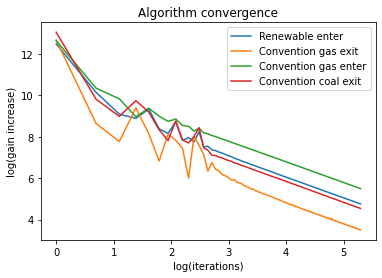

In [18]:
# Algorithm convergence illustration
logIter = np.log(range(1,Niter,1))

plt.figure()
plt.plot(logIter, np.log(save_ob_R[1:]), label = "Renewable enter")
plt.plot(logIter, np.log(save_ob_G[1:]), label = "Convention gas exit")
plt.plot(logIter, np.log(save_ob_G_enter[1:]), label = "Convention gas enter")
plt.plot(logIter, np.log(save_ob_C[1:]), label = "Convention coal exit")
plt.title("Algorithm convergence")
plt.xlabel('log(iterations)')
plt.ylabel('log(gain increase)')
plt.legend()
plt.show()

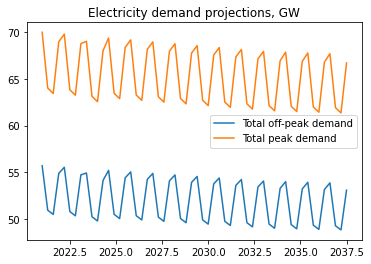

In [19]:
# Electricity demand projections, GW
plt.figure()
plt.plot(2021+T[:56],opdemand[:56],label='Total off-peak demand')
plt.plot(2021+T[:56],pdemand[:56],label='Total peak demand')
plt.title('Electricity demand projections, GW')
plt.legend()
plt.show()

Text(0.5, 0.92, 'Renewable')

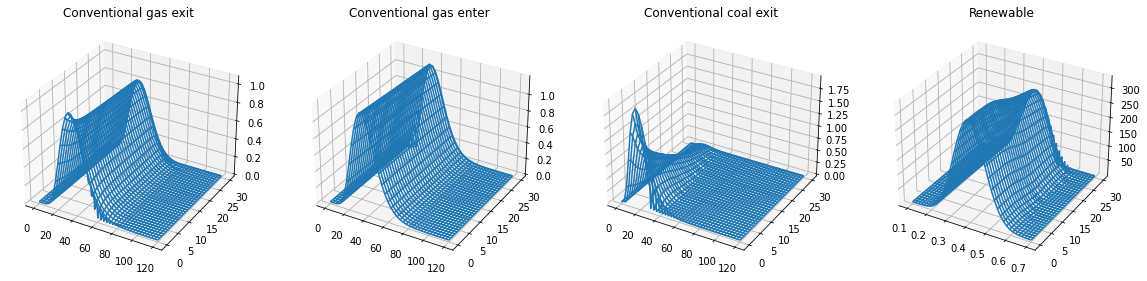

In [20]:
from mpl_toolkits.mplot3d import Axes3D # This import has side effects required for the kwarg projection='3d' in the call to fig.add_subplot

fig = plt.figure(figsize=(20,10))


newOm = np.reshape(Omega,(Nt,NC))
ax = fig.add_subplot(141, projection='3d')
XX, YY = np.meshgrid(C, T)
ax.plot_wireframe(XX, YY, newOm)
plt.title('Conventional gas exit')

newLamb = np.reshape(Lambda,(Nt,NC))
ax = fig.add_subplot(142, projection='3d')
XX, YY = np.meshgrid(C, T)
ax.plot_wireframe(XX, YY, newLamb)
plt.title('Conventional gas enter')

newMu = np.reshape(Mu,(Nt,NC))
ax = fig.add_subplot(143, projection='3d')
XX, YY = np.meshgrid(C, T)
ax.plot_wireframe(XX, YY, newMu)
plt.title('Conventional coal exit')

newEta = np.reshape(Eta,(Nt,NS))
XX, YY = np.meshgrid(S, T)
ax2 = fig.add_subplot(144, projection='3d')
ax2.plot_wireframe(XX, YY, newEta)
plt.title('Renewable')

Text(0.5, 1.0, 'Renewable')

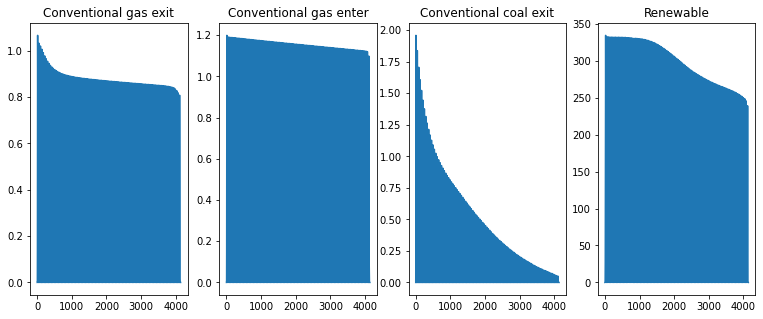

In [21]:
plt.figure(figsize=(13,5))

plt.subplot(1,4,1)
plt.plot(Omega)
plt.title('Conventional gas exit')

plt.subplot(1,4,2)
plt.plot(Lambda)
plt.title('Conventional gas enter')

plt.subplot(1,4,3)
plt.plot(Mu)
plt.title('Conventional coal exit')

plt.subplot(1,4,4)
plt.plot(Eta)
plt.title('Renewable')

Text(0.5, 1.0, 'Renewable')

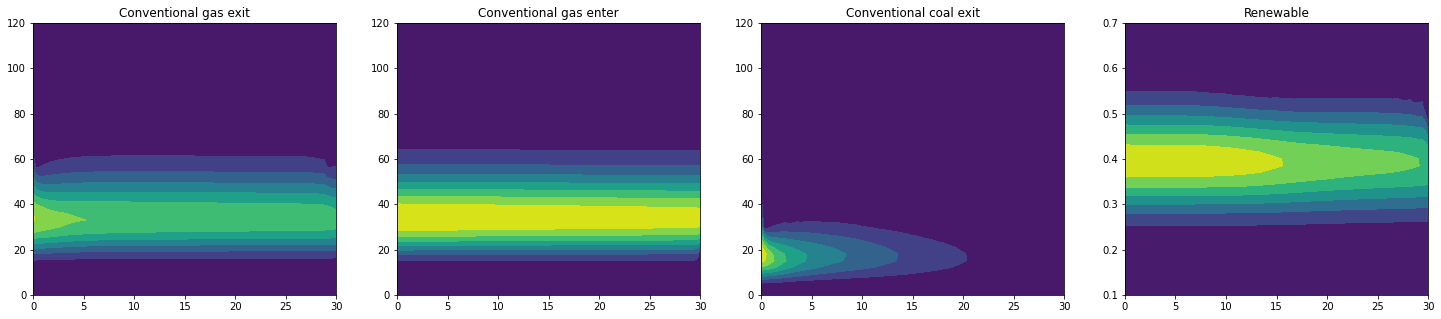

In [22]:
plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
XX, YY = np.meshgrid(C, T)
plt.contourf(YY, XX, newOm)
plt.title('Conventional gas exit')

plt.subplot(1,4,2)
XX, YY = np.meshgrid(C, T)
plt.contourf(YY, XX, newLamb)
plt.title('Conventional gas enter')

plt.subplot(1,4,3)
XX, YY = np.meshgrid(C, T)
plt.contourf(YY, XX, newMu)
plt.title('Conventional coal exit')

plt.subplot(1,4,4)
XX, YY = np.meshgrid(S, T)
plt.contourf(YY, XX, newEta)
plt.title('Renewable')

<ipython-input-23-25eb58102382>:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('231')
<ipython-input-23-25eb58102382>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('232')
<ipython-input-23-25eb58102382>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('233')
<ipython-input-23-25eb58102382>:27: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('234')
<ipython-input-23-25eb58102382>:33: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is

Text(0.5, 1.0, 'Conventional installed capacity')

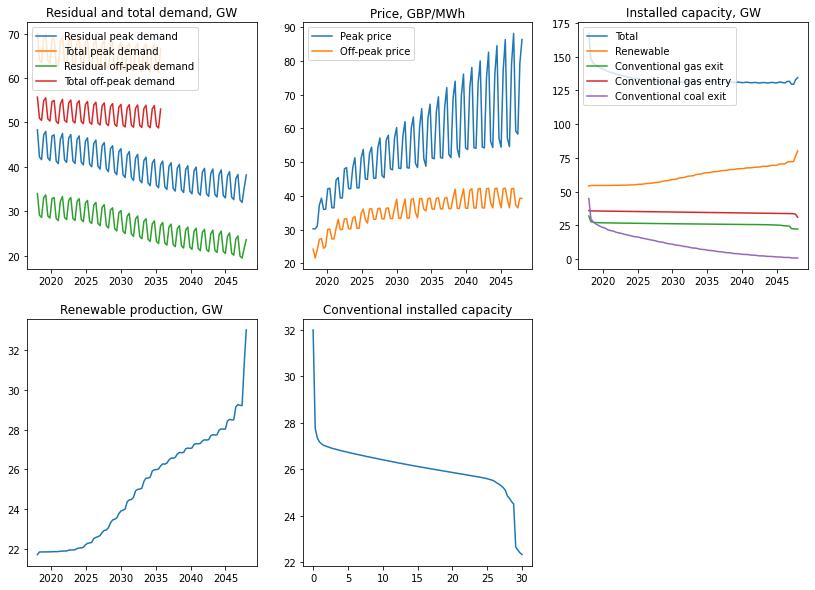

In [23]:
plt.figure(figsize=(14,10))

plt.subplot('231')
plt.plot(2018+T,RRp[:,Niter-1],label='Residual peak demand')
plt.plot(2018+T[:60],pdemand[:60],label='Total peak demand')
plt.plot(2018+T,RRop[:,Niter-1],label='Residual off-peak demand')
plt.plot(2018+T[:60],opdemand[:60],label='Total off-peak demand')
plt.title('Residual and total demand, GW')
plt.legend(loc=2)

plt.subplot('232')
plt.plot(2018+T,prphist[:,Niter-1],label='Peak price')
plt.plot(2018+T,prophist[:,Niter-1],label='Off-peak price')
plt.legend(loc=2)
plt.title('Price, GBP/MWh')

plt.subplot('233')
renhist = np.ones(penhist.shape)*np.sum(BarEta)*dS-penhist
plt.plot(2018+T,renhist[:,Niter-1]+g_exit_hist[:,Niter-1]+g_enter_hist[:,Niter-1]+c_hist[:,Niter-1],label='Total')
plt.plot(2018+T,renhist[:,Niter-1],label='Renewable')
plt.plot(2018+T,g_exit_hist[:,Niter-1],label='Conventional gas exit')
plt.plot(2018+T,g_enter_hist[:,Niter-1],label='Conventional gas entry')
plt.plot(2018+T,c_hist[:,Niter-1],label='Conventional coal exit')
plt.legend(loc=2)
plt.title('Installed capacity, GW')

plt.subplot('234')
plt.plot(2018+T,np.sum(BarEta*S)*dS-renpen[:,Niter-1])
plt.title('Renewable production, GW')

#plt.savefig('industry_dynamics_peak_offpeak_baseline.pdf',format='pdf')

plt.subplot('235')
plt.plot(T,g_exit_hist[:,-1])
plt.title('Conventional installed capacity')

In [24]:
print(prphist[:,Niter-1])

[30.25315744 30.24830087 31.06998975 37.3349939  39.32205353 36.00696972
 36.06945638 42.0893439  42.30510339 36.48069443 36.47767191 44.71876833
 45.46912963 39.40254958 39.37391083 48.03168352 48.41482658 42.15482383
 42.11436601 48.47901547 51.31179279 42.43464138 42.38292295 51.22950127
 53.80182774 45.06300491 44.91431852 52.64867608 54.45800033 45.27736841
 45.19424367 54.30149066 57.1835588  46.03368213 45.40407179 56.55845698
 58.00888365 48.07738017 47.72904557 57.34600192 60.27814405 48.23679792
 48.1383052  57.86153719 62.02354329 48.37232229 48.2478438  60.10264116
 63.43019877 49.67145466 48.4140527  60.6166822  65.88192898 51.08123892
 48.79412264 63.14330646 67.19842168 51.21794135 51.03615195 64.88845033
 69.39848973 51.37217027 51.21491416 66.4082672  72.0951386  52.2801405
 51.35874949 68.89678301 74.03446831 54.08041062 51.49573412 69.93129099
 76.11522454 54.2260288  53.75841463 72.06400262 78.0912861  54.31436951
 54.10030873 73.3241445  80.02347943 54.47747844 54.

In [25]:
print(prophist[:,Niter-1])

[24.22552417 21.58211791 24.05724119 27.11883743 27.34509993 24.45424804
 25.04755675 30.06463523 30.18869508 27.24136524 27.27117153 30.36852114
 33.04689576 30.03570748 30.04205099 33.15179491 33.30480734 30.253854
 30.24659008 33.36370202 33.90718892 30.42803262 30.41015606 34.81771341
 36.11298342 33.00807833 31.95415643 36.10327692 36.24924337 33.11953896
 33.08685487 36.2296956  36.362496   33.22841633 33.18931568 36.33628205
 36.45789075 33.30124625 33.27092937 36.43726788 39.00813112 33.38232442
 33.34748064 36.49188438 39.09316247 33.45052444 33.40332352 39.00905959
 39.18432174 35.03523586 33.48768855 39.10346886 39.25468737 36.04381893
 35.57175984 39.18111849 39.34130509 36.11149708 36.05549766 39.2774168
 39.42451138 36.18706494 36.13491095 39.35848014 39.57374664 36.2660293
 36.20504762 39.42804651 42.01518302 36.33400892 36.2716273  39.49163102
 42.09153282 36.39024875 36.32381798 41.58406396 42.14844055 36.42630882
 36.36923402 42.05078132 42.2125533  36.48946864 36.419

In [26]:
print(g_enter_hist[:,Niter-1])

[35.99985522 35.81153703 35.76664226 35.74409445 35.72206639 35.70031735
 35.67873264 35.65725344 35.63584746 35.61449582 35.5931868  35.57191276
 35.55066848 35.52945024 35.50825534 35.4870817  35.46592775 35.44479225
 35.42367419 35.40257278 35.38148735 35.36041737 35.33936239 35.31832202
 35.29729595 35.27628391 35.25528568 35.23430105 35.21332988 35.192372
 35.1714273  35.15049568 35.12957704 35.1086713  35.08777839 35.06689825
 35.04603083 35.02517607 35.00433395 34.98350442 34.96268744 34.94188299
 34.92109105 34.90031158 34.87954457 34.85879    34.83804784 34.81731809
 34.79660072 34.77589573 34.75520309 34.7345228  34.71385485 34.69319922
 34.6725559  34.65192488 34.63130616 34.61069972 34.59010555 34.56952365
 34.548954   34.5283966  34.50785144 34.48731851 34.46679781 34.44628932
 34.42579303 34.40530895 34.38483705 34.36437734 34.34392981 34.32349445
 34.30307124 34.28266019 34.26226129 34.24187452 34.22149989 34.20113738
 34.18078699 34.1604487  34.14012252 34.11980844 34.0

In [27]:
print(g_exit_hist[:,Niter-1])

[31.99987131 27.77207399 27.34915008 27.18071774 27.09329677 27.02986381
 26.99538494 26.9643337  26.93502283 26.90305482 26.87846344 26.85551804
 26.83268035 26.80712601 26.78489237 26.76441865 26.74266341 26.71973041
 26.69930711 26.67904653 26.6592964  26.63857322 26.61920656 26.60069715
 26.58076267 26.56022552 26.54105833 26.52274406 26.50422853 26.48547137
 26.46717769 26.44926921 26.4298656  26.41077473 26.39348026 26.37487139
 26.35684712 26.33868374 26.32084853 26.30318325 26.28557216 26.26787639
 26.25123323 26.23444358 26.21658092 26.19992382 26.1832038  26.16648235
 26.1497671  26.13352377 26.11755654 26.10151507 26.08568581 26.06992971
 26.0542642  26.03870178 26.02317226 26.00764518 25.99214639 25.97666932
 25.96120129 25.94573174 25.93027997 25.91484449 25.89941795 25.88399351
 25.86858381 25.85318596 25.83779796 25.822416   25.80704806 25.79168947
 25.77634007 25.76099639 25.74566567 25.73034514 25.7150336  25.69972936
 25.68429996 25.66867577 25.65268293 25.63606168 25

In [28]:
print(c_hist[:,Niter-1])

[44.90047032 29.91721691 27.74032372 26.50354778 25.54315608 24.73979449
 23.92775544 23.44648983 22.87070331 21.80605819 21.36801602 21.07047037
 20.69402957 19.98976235 19.64535442 19.32359341 18.96161069 18.47094663
 18.11156091 17.77411574 17.42264954 17.03092169 16.6873124  16.50479192
 16.2837511  15.82263372 15.48617144 15.18785864 14.86534145 14.51450795
 14.21907833 13.93557952 13.65464026 13.070694   12.82900026 12.60980262
 12.3725795  11.86756706 11.51460057 11.35273065 11.14571665 10.70936901
 10.3998463  10.25734945 10.05933348  9.64725664  9.37781635  9.24935038
  8.94222443  8.48981279  8.29669959  8.19268728  7.93695932  7.48447512
  7.33548386  7.17212707  6.99355461  6.61100051  6.48276955  6.3381708
  6.18730568  5.84400949  5.63220376  5.534423    5.41427152  5.03188917
  4.87587463  4.798701    4.7016614   4.29266334  4.18347582  4.12380147
  4.04390915  3.68866591  3.58917683  3.53907537  3.47510145  3.18816469
  3.03681767  3.00115712  2.90941421  2.57094356  2.

In [29]:
print(renhist[:,Niter-1])

[54.29895728 54.62287231 54.62489694 54.62763745 54.63056709 54.63270719
 54.63541378 54.64769621 54.65409265 54.65679479 54.66136203 54.70110273
 54.71628662 54.72122516 54.7315139  54.81540625 54.83697842 54.84843668
 54.8647262  54.97870175 55.0350923  55.05187284 55.10337609 55.3445183
 55.48333775 55.53418386 55.60501434 55.97007003 56.0849354  56.1826925
 56.30685885 56.61163573 56.83111265 56.91732559 57.15186808 57.63360832
 57.94846286 58.07621105 58.25059581 58.68953029 59.00286875 59.13264503
 59.30343757 60.03341909 60.28065995 60.39725195 60.65545621 61.32390439
 61.55012713 61.65984294 61.8081947  62.51381678 62.89860731 62.98873757
 63.15909845 63.79152113 63.99696677 64.09870022 64.2349671  64.58010125
 64.84165011 64.89220805 65.05462675 65.40974258 65.64410724 65.69438933
 65.84063366 66.19711031 66.39911901 66.44946463 66.52541751 66.90977733
 67.03591354 67.06173749 67.15212257 67.51509039 67.64774279 67.67339632
 67.76019331 68.0285964  68.17762325 68.20201348 68.2